In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

import sklearn_tda as sktda
# Can be downloaded at https://github.com/MathieuCarriere/sklearn-tda
import statmapper as stm
# Can be downloaded at https://github.com/MathieuCarriere/statmapper
from metricmapper import *
from voronoicover import *


%matplotlib inline

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [2]:
X_test_re = X_test.reshape(10000,-1)
clustering = KMeans(n_clusters=10)
M = clustering.fit_predict(X_test_re)

In [3]:
r = np.arange(np.max(M))
count = dict.fromkeys(r, 0)
for i in r:
    for clus in M:
        count[i] += (i==clus)
print(count)

{0: 883, 1: 953, 2: 1324, 3: 1248, 4: 879, 5: 865, 6: 798, 7: 1185, 8: 1106}


In [4]:
samples = np.ones((10,10))
for j in range(10):
    idxs_j = np.argwhere(M==j)
    samples[j,:] = np.random.choice(idxs_j.reshape(-1), 10)
samples = samples.astype(int)
#print(samples)

<IPython.core.display.Javascript object>


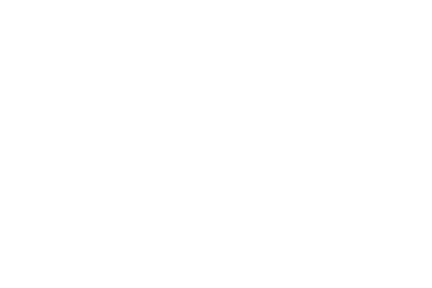

In [5]:
%matplotlib notebook
fig, axs = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(X_test[samples[i,j]].reshape((28,28)), cmap='Greys')
#plt.show()

In [6]:
def twolayerFC():
    input_shape = (28,28,1)
    hidden_layer_size, num_classes = 400, 10
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu', kernel_initializer = initializer),
        tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer = initializer)
    ]
    model = tf.keras.Sequential(layers)
    return model

In [7]:
lr = 1e-3
model = twolayerFC()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0, nesterov = True), 
             loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=64, epochs=10)
model.evaluate(X_test, y_test)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 22us/sample - loss: 3.8559 - sparse_categorical_accuracy: 0.8829
Epoch 2/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.4854 - sparse_categorical_accuracy: 0.9333
Epoch 3/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.2764 - sparse_categorical_accuracy: 0.9510
Epoch 4/10
60000/60000 [==============================] - 1s 20us/sample - loss: 0.1775 - sparse_categorical_accuracy: 0.9631
Epoch 5/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.1256 - sparse_categorical_accuracy: 0.9708
Epoch 6/10
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0925 - sparse_categorical_accuracy: 0.9770
Epoch 7/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0728 - sparse_categorical_accuracy: 0.9808
Epoch 8/10
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0576 - spars

[0.44127650326547446, 0.9411]

In [8]:
A = np.array([0,1,2,1,2,1,0])
x = 2
print(np.argwhere(np.unique(A) == x)[0,0] + 10)

12


In [17]:
np.random.seed(0)

X_test_re = X_test.reshape(X_test.shape[0],-1)
filters = model.predict(X_test[0:10000])
num_filters = filters.shape[1]
cover = FixedVoronoiCover(d=num_filters, threshold = 0.05)

mapper = MetricMapperComplex(filters=filters, colors=filters, codomain="vectors",
                       correct_Rips=False, delta=1., num_subdivisions=1,
                       cover=cover, distance=EuclideanDistance(), 
                       domain="point cloud", clustering=KMeans(n_clusters=10), 
                       mask=20)
mapper.fit(X_test_re[0:10000])

MetricMapperComplex(bnds=(nan, nan),
                    clustering=KMeans(algorithm='auto', copy_x=True,
                                      init='k-means++', max_iter=300,
                                      n_clusters=10, n_init=10, n_jobs=None,
                                      precompute_distances='auto',
                                      random_state=None, tol=0.0001,
                                      verbose=0),
                    codomain='vectors',
                    colors=array([[0.0000000e+00, 5.1207935e-28, 2.3955041e-20, ..., 1.0000000e+00,
        2.2392339e-29, 2.3455198e-18],
       [0.0000000e...
       [5.1137437e-26, 7.3459374e-21, 6.7425948e-13, ..., 4.4104763e-07,
        3.0885677e-10, 3.9400041e-04],
       [2.1913686e-31, 6.9752615e-33, 5.1165721e-37, ..., 1.3777246e-25,
        5.9374214e-11, 1.5170202e-30],
       [2.9684371e-15, 2.9303141e-26, 1.2705399e-13, ..., 4.2026285e-24,
        8.8605860e-17, 3.6265379e-19]], dtype=float32),
       

<IPython.core.display.Javascript object>


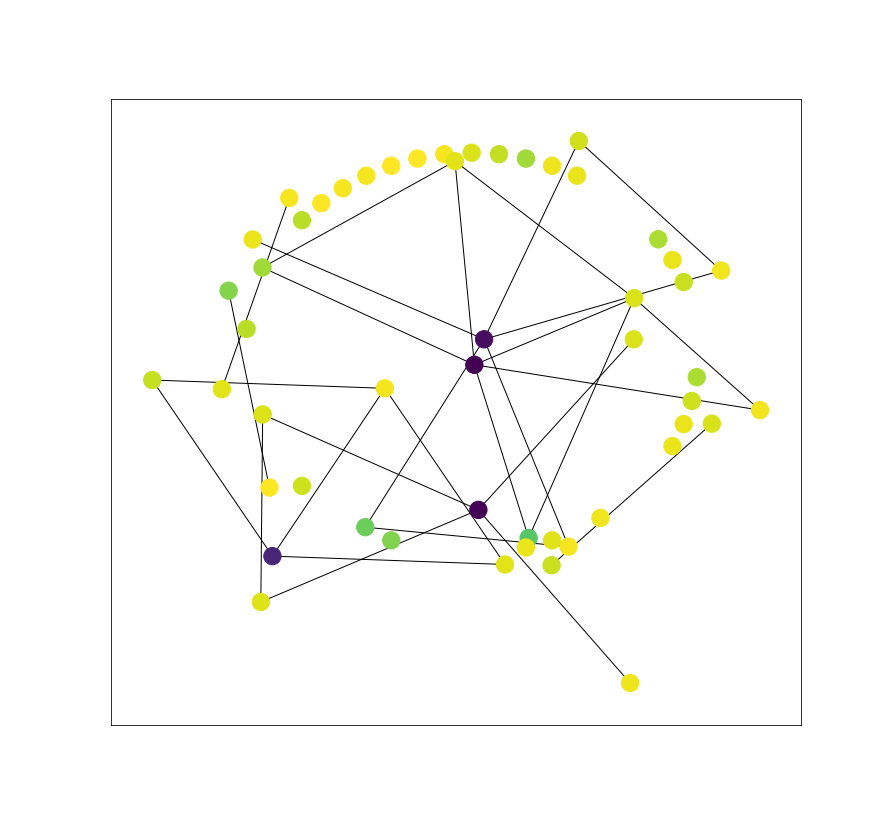

/home/jscott/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [18]:
%matplotlib notebook
G = stm.mapper2networkx(mapper)
plt.figure()
nx.draw_networkx(G, with_labels=False, pos=nx.kamada_kawai_layout(G), 
                 node_color=[np.var(mapper.node_info_[name]["colors"]) for name in G.nodes()])

In [11]:
vor = FixedVoronoiCover(d=10, threshold = 0.05)
vor.fit(filters)
for i in range(10000):
    num_occurs = 0
    keys = []
    for key in vor.binned_data.keys():
        num_occurs += (i in vor.binned_data[key])
        if i in vor.binned_data[key]:
            keys.append(key)
    if num_occurs > 2:
        print("Point %d occurs %d times" % (i,num_occurs) + " in " + str(keys))

Point 497 occurs 3 times in [4, 8, 10]
Point 936 occurs 3 times in [8, 3, 10]
Point 938 occurs 3 times in [5, 3, 10]
Point 950 occurs 3 times in [7, 2, 10]
Point 1107 occurs 3 times in [8, 3, 10]
Point 2464 occurs 3 times in [4, 9, 10]
Point 2760 occurs 3 times in [4, 9, 10]
Point 2930 occurs 3 times in [9, 5, 10]
Point 2945 occurs 3 times in [9, 3, 10]
Point 3402 occurs 3 times in [4, 6, 10]
Point 3529 occurs 3 times in [4, 9, 10]
Point 3667 occurs 3 times in [7, 9, 10]
Point 4072 occurs 3 times in [5, 3, 10]
Point 7864 occurs 3 times in [9, 3, 10]
Point 8183 occurs 3 times in [8, 5, 10]
Point 8362 occurs 3 times in [5, 3, 10]
Point 9638 occurs 3 times in [7, 9, 10]


In [12]:
from sklearn.metrics import pairwise_distances
pt = filters[4692].reshape(1,-1)
#print(pt.shape)
germs = np.array([[1,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,1], [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]])
print(pairwise_distances(pt,germs))

[[1.41418288e+00 6.08573174e-05 9.48637562e-01]]
